In [1]:
import ee
import geopandas
import numpy as np
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import box
import warnings
from functools import reduce
from math import sin, cos, sqrt, atan2, radians, isnan
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, metrics
import seaborn as sns
from scipy.stats.stats import pearsonr
import hdbscan
from scipy.stats import ks_2samp, mannwhitneyu, kruskal, ttest_ind
from itertools import combinations 
from keras.models import load_model
import pickle
from shapely.geometry import box

Using TensorFlow backend.


In [2]:
# Trigger the authentication flow.
# ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [3]:
# India
center_lon = 73.42
center_lat = 24.35
edge_len = 0.1
year=2018
resolution=30

In [4]:
gfsad30 = ee.ImageCollection('users/ajsohn/GFSAD30')
gfsad30_lst = gfsad30.toList(gfsad30.size())
for i in range(gfsad30.size().getInfo()):
    img = ee.Image(gfsad30_lst.get(i))
    region = img.getInfo()['id'].split('/')[3]
    if region == 'se_asia_mos':
        gfsad30_se_asia_image = img
    print(region)

africa_mos
aus_chn_mos
eu_me_1_mos
eu_me_2_mos
eu_me_3_mos
ne_asia_mos
north_america_mos
se_asia_mos
south_america_mos


In [5]:
area_of_interest_shapely = box(center_lon-edge_len/2, center_lat-edge_len/2, center_lon+edge_len/2, center_lat+edge_len/2)

def add_ee_layer(self, ee_object, vis_params, name):
    try:    
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                tiles = map_id_dict['tile_fetcher'].url_format,
                attr = 'Google Earth Engine',
                name = name,
                overlay = True,
                control = True
                ).add_to(self)
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.median()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                tiles = map_id_dict['tile_fetcher'].url_format,
                attr = 'Google Earth Engine',
                name = name,
                overlay = True,
                control = True
                ).add_to(self)
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
                    data = ee_object.getInfo(),
                    name = name,
                    overlay = True,
                    control = True
                ).add_to(self)
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = name,
                    overlay = True,
                    control = True
                ).add_to(self)

    except:
        print("Could not display {}".format(name))
folium.Map.add_ee_layer = add_ee_layer            

In [36]:
myMap = folium.Map(location=[center_lat, center_lon], zoom_start=8)
# Add the box around the area of interest
folium.GeoJson(area_of_interest_shapely, name="Area of Interest").add_to(myMap)
#     0: Non-croplands
#     1: Croplands: irrigation major
#     2: Croplands: irrigation minor
#     3: Croplands: rainfed
#     4: Croplands: rainfed, minor fragments
#     5: Croplands: rainfed, rainfed, very minor fragments
visParams = {'min':0, 'max':5, 'palette':['black', 'orange', 'brown', '02a50f', 'purple', 'yellow']}
myMap.add_ee_layer(ee.Image("USGS/GFSAD1000_V1"), visParams, name='GFSAD')
myMap

In [7]:
myMap = folium.Map(location=[center_lat, center_lon], zoom_start=8)
# Add the box around the area of interest
folium.GeoJson(area_of_interest_shapely, name="Area of Interest").add_to(myMap)
# 2 = cropland, 0 - water, 1 = non-cropland
visParams = {'min':1, 'max':2, 'palette':['black', 'yellow']}
myMap.add_ee_layer(gfsad30_se_asia_image, visParams, name='GFSAD')
myMap

In [8]:
area_of_interest_ee = ee.Geometry.Rectangle([center_lon-edge_len/2, center_lat-edge_len/2, center_lon+edge_len/2, center_lat+edge_len/2])

def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)

# Reference: https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/
band_blue = 'B2' #10m
band_green = 'B3' #10m
band_red = "B4"  #10m
band_nir = 'B8'  #10m

def calc_NDVI(img):
    ndvi = ee.Image(img.normalizedDifference([band_nir, band_red])).rename(["ndvi"]).copyProperties(img, img.propertyNames())
    composite = img.addBands(ndvi)
    return composite

# SAVI = ((NIR – Red) / (NIR + Red + L)) x (1 + L)
def calc_SAVI(img):
    """A function to compute Soil Adjusted Vegetation Index."""
    savi =  ee.Image(img.expression(
        '(1 + L) * float(nir - red)/ (nir + red + L)',
        {
            'nir': img.select(band_nir),
            'red': img.select(band_red),
            'L': 0.5
        })).rename(["savi"]).copyProperties(img, img.propertyNames())
    composite = img.addBands(savi)
    return composite

# EVI = 2.5 * ((NIR – Red) / ((NIR) + (C1 * Red) – (C2 * Blue) + L))
#     C1=6, C2=7.5, and L=1
def calc_EVI(img):
    """A function to compute Soil Adjusted Vegetation Index."""
    evi = ee.Image(img.expression(
      '(2.5) * float(nir - red)/ ((nir) + (C1*red) - (C2*blue) + L)',
      {   
          'nir': img.select(band_nir),
          'red': img.select(band_red),
          'blue': img.select(band_blue),
          'L': 0.2,
          'C1': 6,
          'C2': 7.5
      })).rename(["evi"]).copyProperties(img, img.propertyNames())
    composite = img.addBands(evi)
    return composite
# 2 = cropland, 0 - water, 1 = non-cropland
def add_GFSAD30(img):
    composite = img.addBands(gfsad30_se_asia_image)
    return composite
#     0: Non-croplands
#     1: Croplands: irrigation major
#     2: Croplands: irrigation minor
#     3: Croplands: rainfed
#     4: Croplands: rainfed, minor fragments
#     5: Croplands: rainfed, rainfed, very minor fragments
def add_landcover(img):
    landcover = ee.Image("USGS/GFSAD1000_V1")
    composite = img.addBands(landcover)
    return composite

def calc_YYYYMM(img):
    return img.set('YYYYMM', img.date().format("YYYYMM"))

In [9]:
%%time

img_calc_month_dict = dict()
data_dict = dict()

for month in range(1, 13):
    month_start = datetime.date(year, month, 1)
    month_end = last_day_of_month(datetime.date(year, month, 1))   


    # Create image collection that contains the area of interest
    img_collect = (ee.ImageCollection('COPERNICUS/S2')
                 .filterDate(str(month_start), str(month_end))
                 .filterBounds(area_of_interest_ee)
                    # Remove image that's too small (likely to be partial image)
                    # Size of a full image: 1,276,131,371; size of a partial image: 276,598,191
#                          .filter(ee.Filter.gt('system:asset_size', 800000000))
#                  .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",50)
                  )


    if img_collect.size().getInfo() == 0:
        warnings.warn('No valid image.')
        continue
    print("Total number of images in the collection: ", img_collect.size().getInfo())

    # Extract tile information from each image
    # Note: tiles can overlap a little bit
    unique_tiles = set([item['properties']['MGRS_TILE'] for item in img_collect.getInfo()['features']])
    if len(unique_tiles) > 1:
        print('Number of tiles selected: ', len(unique_tiles))
#             if img_collect_no_partial.size().getInfo() < img_collect.size().getInfo():
#                 warnings.warn('There are partial images in the collection. Proceed with caution.')
#                 print('Number of partial images: ', img_collect.size().getInfo()-img_collect_no_partial.size().getInfo())


    img_collect_calc = img_collect.map(calc_YYYYMM).map(calc_NDVI).map(calc_SAVI).map(calc_EVI).map(add_GFSAD30).map(add_landcover)

    unique_month = list(set([item['properties']['YYYYMM'] for item in img_collect_calc.getInfo()['features']]))
    unique_month.sort()
    print(unique_month)
    YYYYMM_str = unique_month[0]

    img_calc_month_dict[YYYYMM_str] = img_collect_calc.filter(ee.Filter.eq('YYYYMM',YYYYMM_str)).median()
    img_calc_month2 = img_calc_month_dict[YYYYMM_str].addBands(ee.Image.pixelLonLat())

    data_month_lst = img_calc_month2.reduceRegion(reducer=ee.Reducer.toList(), \
                                                         geometry=area_of_interest_ee, maxPixels=1e13, scale=resolution)
    try:
        lat_series = pd.Series(np.array((ee.Array(data_month_lst.get("latitude")).getInfo())), name="lat")
        lon_series = pd.Series(np.array((ee.Array(data_month_lst.get("longitude")).getInfo())), name="lon")
        ndvi_series = pd.Series(np.array((ee.Array(data_month_lst.get("ndvi")).getInfo())), name=YYYYMM_str+'_NDVI')
        savi_series = pd.Series(np.array((ee.Array(data_month_lst.get("savi")).getInfo())), name=YYYYMM_str+'_SAVI')
        evi_series = pd.Series(np.array((ee.Array(data_month_lst.get("evi")).getInfo())), name=YYYYMM_str+'_EVI')
        b1_series = pd.Series(np.array((ee.Array(data_month_lst.get("b1")).getInfo())), name='GFSAD30')
        landcover_series = pd.Series(np.array((ee.Array(data_month_lst.get("landcover")).getInfo())), name='GFSAD1000')
#         data_dict[YYYYMM_str] = pd.concat([lat_series, lon_series, ndvi_series, b1_series], axis=1)
        data_dict[YYYYMM_str] = pd.concat([lat_series, lon_series, ndvi_series, savi_series, evi_series, b1_series, landcover_series], axis=1)
    except:
        warnings.warn('Missing satellite data.')
    
df_lst = list(data_dict.values())
out_df = reduce(lambda left, right: pd.merge(left,right,on=['lat', 'lon']), df_lst)

Total number of images in the collection:  8
Number of tiles selected:  2
['201801']
Total number of images in the collection:  12
Number of tiles selected:  2
['201802']
Total number of images in the collection:  12
Number of tiles selected:  2
['201803']
Total number of images in the collection:  12
Number of tiles selected:  2
['201804']
Total number of images in the collection:  12
Number of tiles selected:  2
['201805']
Total number of images in the collection:  12
Number of tiles selected:  2
['201806']
Total number of images in the collection:  12
Number of tiles selected:  2
['201807']
Total number of images in the collection:  12
Number of tiles selected:  2
['201808']
Total number of images in the collection:  8
Number of tiles selected:  2
['201809']
Total number of images in the collection:  12
Number of tiles selected:  2
['201810']
Total number of images in the collection:  12
Number of tiles selected:  2
['201811']
Total number of images in the collection:  12
Number of 

In [10]:
out_df.head()

,lat,lon,201805_NDVI,201805_SAVI,201805_EVI,GFSAD30_x,GFSAD1000_x,201804_NDVI,201804_SAVI,201804_EVI,...,201811_NDVI,201811_SAVI,201811_EVI,GFSAD30_x,GFSAD1000_x,201810_NDVI,201810_SAVI,201810_EVI,GFSAD30_y,GFSAD1000_y
0,24.300192,73.370036,0.212605,0.318874,0.751136,1,1,0.191734,0.287568,0.646259,...,0.310166,0.465185,2.726812,1,1,0.402199,0.603212,7.025207,1,1
1,24.300192,73.370305,0.216460,0.324656,0.684028,1,1,0.188404,0.282577,0.562737,...,0.362240,0.543286,2.992551,1,1,0.475656,0.713386,7.139163,1,1
2,24.300192,73.370575,0.220591,0.330848,0.946082,1,1,0.204660,0.306955,0.788134,...,0.425442,0.638065,-6.964831,1,1,0.564301,0.846330,-15.239941,1,1
3,24.300192,73.370844,0.194187,0.291249,0.691439,1,1,0.146595,0.219870,0.474046,...,0.276578,0.414808,2.448549,1,1,0.379793,0.569613,3.784116,1,1
4,24.300192,73.371114,0.217664,0.326459,0.894572,2,1,0.179849,0.269744,0.603345,...,0.359416,0.539054,2.681185,2,1,0.426619,0.639845,4.799347,2,1


In [11]:
out_gfsad_lst = out_df.loc[:, out_df.columns.str.contains('GFSAD30')].values.tolist()
out_gfsad_nodup_lst = [set(i) for i in out_gfsad_lst]
gfsad_no_nan_lst = []
for i in out_gfsad_nodup_lst:
    new_loop = 1
    for j in list(i):
        # NaN in pd is converted to nan (float) in the set or list
        #     Reference: https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values
        if not isnan(j):
            gfsad_no_nan_lst.append(j)
            new_loop = 0
            break
    if new_loop == 1:
        gfsad_no_nan_lst.append(None)
gfsad30_df = pd.DataFrame(gfsad_no_nan_lst, columns=['GFSAD30'])
out_gfsad_lst = out_df.loc[:, out_df.columns.str.contains('GFSAD1000')].values.tolist()
out_gfsad_nodup_lst = [set(i) for i in out_gfsad_lst]
gfsad_no_nan_lst = []
for i in out_gfsad_nodup_lst:
    new_loop = 1
    for j in list(i):
        # NaN in pd is converted to nan (float) in the set or list
        #     Reference: https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values
        if not isnan(j):
            gfsad_no_nan_lst.append(j)
            new_loop = 0
            break
    if new_loop == 1:
        gfsad_no_nan_lst.append(None)
gfsad1000_df = pd.DataFrame(gfsad_no_nan_lst, columns=['GFSAD1000'])
# Merge no landcover with landcover df
out_no_gfsad_df = out_df.loc[:, ~(out_df.columns.str.contains('GFSAD30')|out_df.columns.str.contains('GFSAD1000'))]
temp_df = pd.merge(gfsad30_df, gfsad1000_df, left_index=True, right_index=True)
out_df2 = pd.merge(temp_df, out_no_gfsad_df, left_index=True, right_index=True)

In [12]:
out_df2

,GFSAD30,GFSAD1000,lat,lon,201805_NDVI,201805_SAVI,201805_EVI,201804_NDVI,201804_SAVI,201804_EVI,...,201803_EVI,201809_NDVI,201809_SAVI,201809_EVI,201811_NDVI,201811_SAVI,201811_EVI,201810_NDVI,201810_SAVI,201810_EVI
0,1,1,24.300192,73.370036,0.212605,0.318874,0.751136,0.191734,0.287568,0.646259,...,0.672743,0.418125,0.627115,4.176827,0.310166,0.465185,2.726812,0.402199,0.603212,7.025207
1,1,1,24.300192,73.370305,0.216460,0.324656,0.684028,0.188404,0.282577,0.562737,...,0.569878,0.496961,0.745365,5.978289,0.362240,0.543286,2.992551,0.475656,0.713386,7.139163
2,1,1,24.300192,73.370575,0.220591,0.330848,0.946082,0.204660,0.306955,0.788134,...,0.980810,0.555944,0.833827,-3.726071,0.425442,0.638065,-6.964831,0.564301,0.846330,-15.239941
3,1,1,24.300192,73.370844,0.194187,0.291249,0.691439,0.146595,0.219870,0.474046,...,0.533483,0.507550,0.761241,-3.676955,0.276578,0.414808,2.448549,0.379793,0.569613,3.784116
4,2,1,24.300192,73.371114,0.217664,0.326459,0.894572,0.179849,0.269744,0.603345,...,0.585679,0.518332,0.777412,-8.998281,0.359416,0.539054,2.681185,0.426619,0.639845,4.799347
5,2,1,24.300192,73.371383,0.185987,0.278948,0.783077,0.160749,0.241096,0.547885,...,0.606904,0.444415,0.666546,-2.451527,0.297594,0.446337,1.870182,0.387683,0.581453,3.909487
6,2,1,24.300192,73.371653,0.128190,0.192260,0.710137,0.125110,0.187641,0.540743,...,0.532901,0.301894,0.452776,-3.418669,0.183191,0.274748,1.012544,0.268144,0.402163,2.628248
7,2,1,24.300192,73.371922,0.107966,0.161927,0.645693,0.091807,0.137692,0.518686,...,0.538193,0.234483,0.351674,-0.678156,0.131245,0.196837,0.860079,0.178365,0.267502,-0.485712
8,2,1,24.300192,73.372192,0.140962,0.211420,0.538894,0.111421,0.167111,0.405516,...,0.550176,0.271579,0.407308,-0.591632,0.239964,0.359896,2.218886,0.264982,0.397414,2.630925
9,2,1,24.300192,73.372461,0.286636,0.429906,1.285234,0.221842,0.332721,1.137012,...,1.577130,0.443855,0.665692,-0.851235,0.463619,0.695331,9.557836,0.473226,0.709737,94.308517


In [13]:
# out_df2[['lat', 'lon', 'GFSAD30']].to_csv('../data/test_graph.csv')

In [14]:
out_df2['GFSAD30'].value_counts()

1    94798
2    42843
Name: GFSAD30, dtype: int64

In [15]:
model_df = out_df2[out_df2['GFSAD30']==2]
model_df

,GFSAD30,GFSAD1000,lat,lon,201805_NDVI,201805_SAVI,201805_EVI,201804_NDVI,201804_SAVI,201804_EVI,...,201803_EVI,201809_NDVI,201809_SAVI,201809_EVI,201811_NDVI,201811_SAVI,201811_EVI,201810_NDVI,201810_SAVI,201810_EVI
4,2,1,24.300192,73.371114,0.217664,0.326459,0.894572,0.179849,0.269744,0.603345,...,0.585679,0.518332,0.777412,-8.998281,0.359416,0.539054,2.681185,0.426619,0.639845,4.799347
5,2,1,24.300192,73.371383,0.185987,0.278948,0.783077,0.160749,0.241096,0.547885,...,0.606904,0.444415,0.666546,-2.451527,0.297594,0.446337,1.870182,0.387683,0.581453,3.909487
6,2,1,24.300192,73.371653,0.128190,0.192260,0.710137,0.125110,0.187641,0.540743,...,0.532901,0.301894,0.452776,-3.418669,0.183191,0.274748,1.012544,0.268144,0.402163,2.628248
7,2,1,24.300192,73.371922,0.107966,0.161927,0.645693,0.091807,0.137692,0.518686,...,0.538193,0.234483,0.351674,-0.678156,0.131245,0.196837,0.860079,0.178365,0.267502,-0.485712
8,2,1,24.300192,73.372192,0.140962,0.211420,0.538894,0.111421,0.167111,0.405516,...,0.550176,0.271579,0.407308,-0.591632,0.239964,0.359896,2.218886,0.264982,0.397414,2.630925
9,2,1,24.300192,73.372461,0.286636,0.429906,1.285234,0.221842,0.332721,1.137012,...,1.577130,0.443855,0.665692,-0.851235,0.463619,0.695331,9.557836,0.473226,0.709737,94.308517
13,2,1,24.300192,73.373539,0.138158,0.207212,0.652731,0.133386,0.200054,0.555493,...,0.532792,0.305218,0.457761,-0.604069,0.188245,0.282328,1.444861,0.282921,0.424321,3.006355
14,2,1,24.300192,73.373809,0.105994,0.158974,0.393891,0.091319,0.136963,0.338952,...,0.360004,0.181357,0.272002,0.395004,0.122783,0.184150,0.656727,0.159905,0.239827,0.982649
15,2,1,24.300192,73.374078,0.117988,0.176965,0.412514,0.096012,0.144004,0.328831,...,0.321498,0.187987,0.281947,0.454014,0.138656,0.207960,0.741957,0.154913,0.232343,0.731987
16,2,1,24.300192,73.374347,0.140429,0.210622,0.520118,0.124932,0.187378,0.421833,...,0.490625,0.259508,0.389210,1.230452,0.271957,0.407879,3.652838,0.284140,0.426160,1.612521


In [16]:
def time_series_prep(in_df, stat_option):
    col_lst = list(in_df.columns)
    col_lst_select = [i for i in col_lst if stat_option in i]
    # Rearrange the order the columns based on YYYYMM
    col_lst_select.sort()
    out_df = in_df[col_lst_select]
    out_df_recenter = out_df - out_df.mean()
    return out_df.to_numpy()

In [17]:
def kmeans(org_arr, in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    model = KMeans(n_clusters=n_classes)
    model.fit(in_arr)
    model.predict(in_arr)
    labels = model.labels_
    centroids = model.cluster_centers_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    # Range from -1 to 1, high is better
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    # High is better
    print('Calinski-Harabasz Index is: ', metrics.calinski_harabasz_score(org_arr, labels))
    # 0 is the best
    print('Davies-Bouldin Index is: ', metrics.davies_bouldin_score(org_arr, labels))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels, centroids

In [18]:
aoi_arr = time_series_prep(in_df=model_df, stat_option='NDVI')

Silhouette Coefficient is:  0.3076550824854625
Calinski-Harabasz Index is:  31835.45433286137
Davies-Bouldin Index is:  1.167540260808118


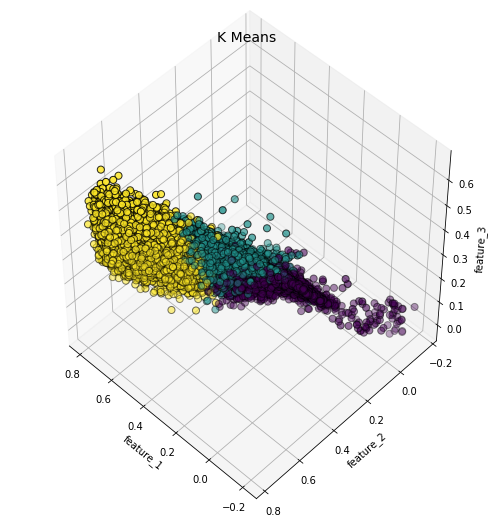

In [19]:
aoi_label, clus_centroids = kmeans(org_arr=aoi_arr, in_arr=aoi_arr, n_classes=3)

Silhouette Coefficient is:  0.4400461481305665
Calinski-Harabasz Index is:  39555.612053146404
Davies-Bouldin Index is:  0.9562354793685176


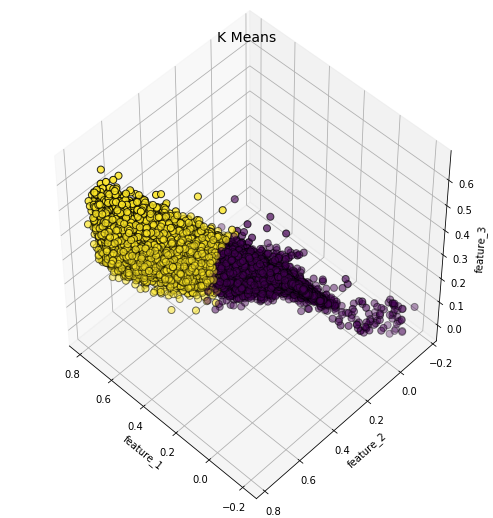

In [20]:
aoi_label, clus_centroids = kmeans(org_arr=aoi_arr, in_arr=aoi_arr, n_classes=2)

In [21]:
clus_centroids

array([[0.25364352, 0.22274335, 0.18080173, 0.16205676, 0.17299433,
        0.13219937, 0.02449797, 0.05381102, 0.40370867, 0.38550789,
        0.28864941, 0.24966211],
       [0.57150263, 0.55690272, 0.31981059, 0.17529119, 0.17609996,
        0.1364966 , 0.02775879, 0.04876435, 0.47070856, 0.38759148,
        0.25433699, 0.32336717]])

In [22]:
%%time

img_calc_month_dict = dict()
data_dict = dict()
pixel_dict = dict()

for month in range(1, 13):
    month_start = datetime.date(year, month, 1)
    month_end = last_day_of_month(datetime.date(year, month, 1))   


    # Create image collection that contains the area of interest
    img_collect = (ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
                 .filterDate(str(month_start), str(month_end))
                 .filterBounds(area_of_interest_ee)
                  )


    if img_collect.size().getInfo() == 0:
        warnings.warn('No valid image.')
        continue
    print("Total number of images in the collection: ", img_collect.size().getInfo())

    img_collect_calc = img_collect.map(calc_YYYYMM)

    unique_month = list(set([item['properties']['YYYYMM'] for item in img_collect_calc.getInfo()['features']]))
    unique_month.sort()
    print(unique_month)
    YYYYMM_str = unique_month[0]

    img_calc_month_dict[YYYYMM_str] = img_collect_calc.filter(ee.Filter.eq('YYYYMM',YYYYMM_str)).first()
    img_calc_month2 = img_calc_month_dict[YYYYMM_str].addBands(ee.Image.pixelLonLat())

    data_month_lst = img_calc_month2.reduceRegion(reducer=ee.Reducer.toList(), \
                                                         geometry=ee.Geometry.Point((center_lon, center_lat)), maxPixels=1e13, scale=resolution)
        
#     pixel_dict['lat'] = ee.Array(data_month_lst.get("latitude")).getInfo()[0]
#     pixel_dict['lon'] = ee.Array(data_month_lst.get("longitude")).getInfo()[0]
    try:
        pixel_dict[YYYYMM_str+'_aet'] = ee.Array(data_month_lst.get("aet")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_def'] = ee.Array(data_month_lst.get("def")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_pdsi'] = ee.Array(data_month_lst.get("pdsi")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_pet'] = ee.Array(data_month_lst.get("pet")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_pr'] = ee.Array(data_month_lst.get("pr")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_ro'] = ee.Array(data_month_lst.get("ro")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_soil'] = ee.Array(data_month_lst.get("soil")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_srad'] = ee.Array(data_month_lst.get("srad")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_swe'] = ee.Array(data_month_lst.get("swe")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_tmmn'] = ee.Array(data_month_lst.get("tmmn")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_tmmx'] = ee.Array(data_month_lst.get("tmmx")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_vap'] = ee.Array(data_month_lst.get("vap")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_vpd'] = ee.Array(data_month_lst.get("vpd")).getInfo()[0]
        pixel_dict[YYYYMM_str+'_vs'] = ee.Array(data_month_lst.get("vs")).getInfo()[0]
    except:
        warnings.warn('Missing TerraClimate data.')
#     data_dict[YYYYMM_str] = data_dict[YYYYMM_str].append(pixel_dict, ignore_index=True)
    
# df_lst = list(data_dict.values())
# out_df = reduce(lambda left, right: pd.merge(left,right,on=['lat', 'lon']), df_lst)

Total number of images in the collection:  1
['201801']
Total number of images in the collection:  1
['201802']
Total number of images in the collection:  1
['201803']
Total number of images in the collection:  1
['201804']
Total number of images in the collection:  1
['201805']
Total number of images in the collection:  1
['201806']
Total number of images in the collection:  1
['201807']
Total number of images in the collection:  1
['201808']
Total number of images in the collection:  1
['201809']
Total number of images in the collection:  1
['201810']
Total number of images in the collection:  1
['201811']
Total number of images in the collection:  1
['201812']
CPU times: user 1.91 s, sys: 40 ms, total: 1.95 s
Wall time: 33.4 s


In [23]:
climate_arr = pd.DataFrame(pixel_dict, index=[0]).values[0]

In [24]:
cluster_0 = np.concatenate((clus_centroids[0], climate_arr))
cluster_0

array([ 2.53643521e-01,  2.22743349e-01,  1.80801734e-01,  1.62056760e-01,
        1.72994329e-01,  1.32199374e-01,  2.44979656e-02,  5.38110230e-02,
        4.03708667e-01,  3.85507894e-01,  2.88649408e-01,  2.49662106e-01,
        1.23000000e+02,  7.39000000e+02,  2.80000000e+02,  8.62000000e+02,
        0.00000000e+00,  0.00000000e+00,  4.06000000e+02,  1.99000000e+03,
        0.00000000e+00,  1.01000000e+02,  2.54000000e+02,  8.77000000e+02,
        1.20000000e+02,  1.20000000e+02,  7.50000000e+01,  8.63000000e+02,
        2.50000000e+02,  9.38000000e+02,  0.00000000e+00,  0.00000000e+00,
        3.32000000e+02,  2.30400000e+03,  0.00000000e+00,  1.39000000e+02,
        2.98000000e+02,  8.96000000e+02,  1.88000000e+02,  1.00000000e+02,
        5.60000000e+01,  1.58000000e+03,  1.90000000e+02,  1.63600000e+03,
        1.00000000e+00,  0.00000000e+00,  2.82000000e+02,  2.71900000e+03,
        0.00000000e+00,  1.88000000e+02,  3.48000000e+02,  1.00300000e+03,
        2.98000000e+02,  

In [25]:
cluster_mean = pd.read_csv('Model_prep_mean.csv', header=None).values[0]
cluster_std = pd.read_csv('Model_prep_std.csv', header=None).values[0]

In [26]:
cluster_x = ((cluster_0.reshape(15, 12)-cluster_mean.reshape(15,1))/cluster_std.reshape(15,1)).flatten()

In [27]:
pkl_filename = "Model_GBM.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
pickle_model.predict(np.expand_dims(cluster_x, axis=0))

array([0.])

In [28]:
cluster_1 = np.concatenate((clus_centroids[1], climate_arr))
cluster_x = ((cluster_1.reshape(15, 12)-cluster_mean.reshape(15,1))/cluster_std.reshape(15,1)).flatten()
pickle_model.predict(np.expand_dims(cluster_x, axis=0))

array([0.])

In [29]:
def create_label(row):
    if row['GFSAD1000'] == 0:
        return None
    elif row['GFSAD1000'] in [1, 2]:
        return 1
    elif row['GFSAD1000'] in [3, 4, 5]:
        return 0
    else:
        return None
model_df['GFSAD1000_grp'] = model_df.apply(create_label, axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
model_df['GFSAD1000_grp'].value_counts()

1    40326
0     2517
Name: GFSAD1000_grp, dtype: int64

In [31]:
gfsad1000_mean_df = model_df.groupby(['GFSAD1000_grp']).mean()
gfsad1000_mean_arr = time_series_prep(in_df=gfsad1000_mean_df, stat_option='NDVI')

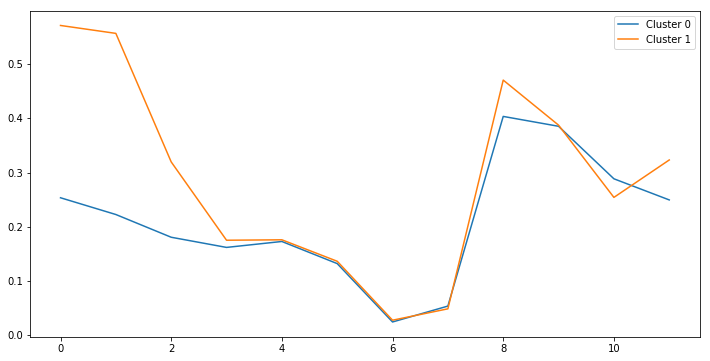

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(clus_centroids[0], label='Cluster ' + str(0))
plt.plot(clus_centroids[1], label='Cluster ' + str(1))
# plt.plot(gfsad1000_mean_arr[0], label='Rainfed')
# plt.plot(gfsad1000_mean_arr[1], label='Irrigated')
plt.legend()

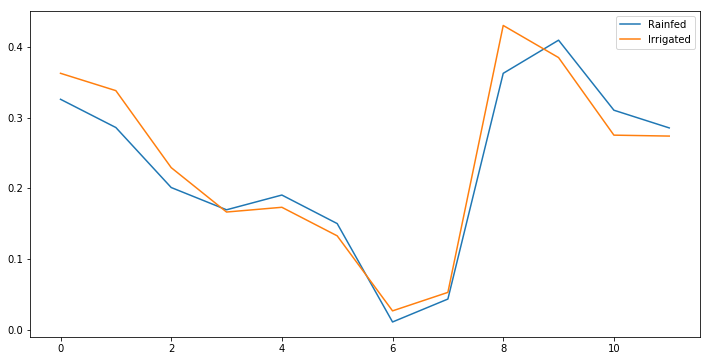

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
# plt.plot(clus_centroids[0], label='Class ' + str(0))
# plt.plot(clus_centroids[1], label='Class ' + str(1))
plt.plot(gfsad1000_mean_arr[0], label='Rainfed')
plt.plot(gfsad1000_mean_arr[1], label='Irrigated')
plt.legend()

In [33]:
print(np.corrcoef(clus_centroids[0], gfsad1000_mean_arr[0]))
print(np.corrcoef(clus_centroids[0], gfsad1000_mean_arr[1]))
print(np.corrcoef(clus_centroids[1], gfsad1000_mean_arr[0]))
print(np.corrcoef(clus_centroids[1], gfsad1000_mean_arr[1]))

[[1.        0.9675609]
 [0.9675609 1.       ]]
[[1.         0.94416012]
 [0.94416012 1.        ]]
[[1.         0.83295486]
 [0.83295486 1.        ]]
[[1.         0.92018938]
 [0.92018938 1.        ]]


In [79]:
aoi_prediction = pd.Series(aoi_label, name="Class", index=model_df.index)
pred_crop_df = model_df[['lat', 'lon']].merge(aoi_prediction.to_frame(), left_index=True, right_index=True)
pred_crop_df['Class'] = pred_crop_df.apply(lambda row: 'Irrigated' if row['Class']==1 else 'Rainfed', axis=1)
pred_crop_df.shape

(42843, 3)

In [81]:
pred_no_crop_df = out_df2[out_df2['GFSAD30']!=2][['lat', 'lon']]
pred_no_crop_df['Class'] = 'Non-cropland'
pred_no_crop_df.shape

(94798, 3)

In [84]:
concatenated = pd.concat([pred_crop_df, pred_no_crop_df])
# concatenated.to_csv('../data/Week10_presentation_prediction.csv')

In [87]:
valuesList = ee.Array(concatenated.values)

# var myFeatures = ee.FeatureCollection(valuesList.map(function(el){
#   el = ee.List(el) // cast every element of the list
#   var geom = ee.Geometry.Point([ee.Number(el.get(0)), ee.Number(el.get(1))])
#   return ee.Feature(geom, {'B4':ee.Number(el.get(2)), 'B5':ee.Number(el.get(3))})
# }))

In [ ]:
# model = load_model('Model_LSTM.h5')

In [18]:
%%time
aoi_image = gfsad30_se_asia_image.addBands(ee.Image.pixelLonLat())
aoi_lst = aoi_image.reduceRegion(reducer=ee.Reducer.toList(), geometry=area_of_interest_ee, maxPixels=1e13, scale=30)
b1_series = pd.Series(np.array((ee.Array(aoi_lst.get("b1")).getInfo())), name='b1')
lat_series = pd.Series(np.array((ee.Array(aoi_lst.get("latitude")).getInfo())), name="lat")
lon_series = pd.Series(np.array((ee.Array(aoi_lst.get("longitude")).getInfo())), name="lon")
temp_df = pd.concat([lat_series, lon_series, b1_series], axis=1)

CPU times: user 140 ms, sys: 10 ms, total: 150 ms
Wall time: 2.09 s


In [20]:
pd.merge(out_df, temp_df, on=['lat', 'lon'])

,lat,lon,201804_NDVI,201802_NDVI,201812_NDVI,201811_NDVI,201809_NDVI,201807_NDVI,201801_NDVI,201810_NDVI,201806_NDVI,201805_NDVI,201808_NDVI,201803_NDVI,b1


In [21]:
temp_df

,lat,lon,b1
0,24.399905,73.370036,2
1,24.399905,73.370305,2
2,24.399905,73.370575,2
3,24.399905,73.370844,2
4,24.399905,73.371114,2
5,24.399905,73.371383,2
6,24.399905,73.371653,2
7,24.399905,73.371922,2
8,24.399905,73.372192,2
9,24.399905,73.372461,2
